## Exploratory Data Anlaysis
In this notebook we explore and understand the data. We also do some cleaning on the questions in order to remove the punctuation, to expand some words for example "Where's" becomes "Where is" and by making lower case the questions. We calculate the distribution length of the questions and the type of questions. Then we calculate the distribution of the answers and we find the weights of the answers, which are the classes, in order to use them in the weighted loss of the model.

In [5]:
# Modules Import
# --------------

import tqdm
import time
from contextlib import contextmanager
import os, argparse
import cv2, spacy, numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

import csv
import glob
import matplotlib
from imutils import paths
import numpy as np
import pickle
import operator
from operator import itemgetter
from itertools import zip_longest
from collections import defaultdict
import json
import joblib
import random
from nltk.tokenize.treebank import TreebankWordTokenizer
import matplotlib.image as mpimg
import pathlib

%matplotlib inline
matplotlib.use("Agg")

os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

ROOT_DIR = pathlib.Path(".")

In [8]:
# Loading of the json file that contains the questions, the answers and the names of the images to use for the training
# --------------

train_data = json.load(open(ROOT_DIR / 'train_questions_annotations.json', 'r'))

print(len(train_data))

58832


In [9]:
# Get the questions, the answers and the names of the images
# --------------

ques = list(map(itemgetter('question'), train_data))
ans = list(map(itemgetter('answer'), train_data))
image_list = list(map(itemgetter('img_path'), train_data))

Populating the interactive namespace from numpy and matplotlib


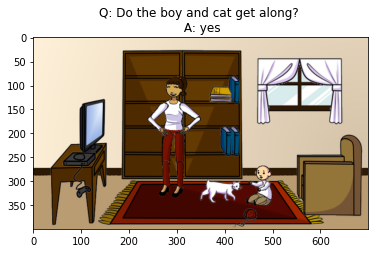

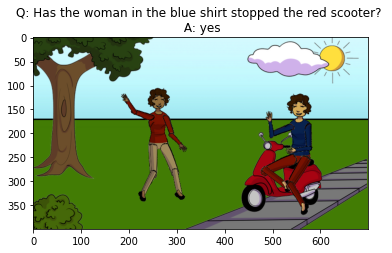

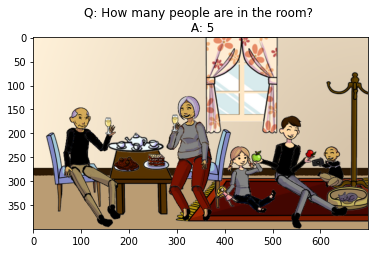

In [10]:
# Print three examples of data items, including the image, the question and the answer
# --------------

%pylab inline
from PIL import Image
import matplotlib.pyplot as plt

for i in range(3):
    index = random.randint(len(image_list))
    image = Image.open(image_list[index])
    plt.figure()
    plt.title(f'Q: {ques[index]} \n A: {ans[index]}')
    plt.imshow(image)

In [11]:
# Extract the words from the questions
# --------------

length_list = []
word_all = []
for i in tqdm.tqdm(ques):
    length_list.append(len(i.split(" ")))
    for j in i.split(" "):
        word_all.append(j)
set_all = set(word_all)

100%|██████████| 58832/58832 [00:00<00:00, 502854.58it/s]


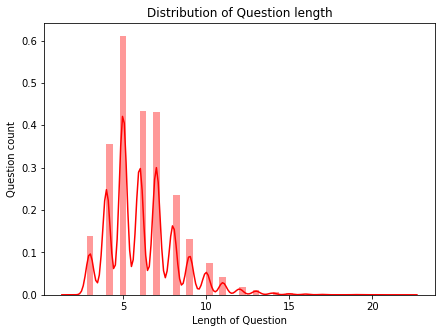

In [12]:
# Plot the distribution of the length (in words) of the questions
# --------------

%matplotlib inline
plt.figure(figsize=(7,5))
sns.distplot(length_list, color='red')
plt.title('Distribution of Question length')
plt.xlabel('Length of Question')
plt.ylabel('Question count')
plt.show()

In [13]:
# Calculate the maximum, minimum and average length of the questions and the number of unique words
# --------------

print('BEFORE DATA CLEANING')
print('-'*35)
print("A sentence has max words:",max(length_list))
print("A sentence has min words:",min(length_list))
print('A sentence has average words:',int(sum(length_list)/len(length_list)))
print('There are total',len(set_all),'unique words')

BEFORE DATA CLEANING
-----------------------------------
A sentence has max words: 22
A sentence has min words: 2
A sentence has average words: 6
There are total 6691 unique words


In [14]:
# Find the characters that are not letters nor numbers
# --------------

list_1 = []
for k in set_all:
    alphabet = 'qwertyuiopasdfghjklzxcvbnmQWERTYUIOPASDFGHJKLZXCVBNM0123456789'
    for l in alphabet:
        k = k.replace(l,'')
    list_1.append(k)

#merge all the non-alphabet characters in 'list_1' to one single list 'set_1'
str_1 = ''
for i in list_1:
    str_1+=i
set_1 = set(str_1)

#concatanate all the special symbols to a single string 'SYMBOLS_TO_REMOVE'
SYMBOLS_TO_REMOVE = ''.join(a for a in set_1)
print('There are total',len(SYMBOLS_TO_REMOVE),'non-alphabet characters (including digits) in our corpus.')

There are total 12 non-alphabet characters (including digits) in our corpus.


In [18]:
# Print the characters that are not letters nor numbers
# --------------

print("These are:")
print(SYMBOLS_TO_REMOVE)

These are:
,'/"(-:`)?.


In [15]:
# Function that cleans the questions, by removing the punctuation and by expanding some words for example "Where's" becomes "Where is"
# --------------

import re

def process_sentence(sentence):
    """
    Cleans a given raw sentence

    Input:
        sentence: a raw sentence

    Returns:
        Returns the cleaned version of the sentence
    """
    # remove the character ".", except from floating numbers
    periodStrip  = re.compile("(?!<=\d)(\.)(?!\d)")
    # remove any "," between digits, eg: 5,6
    commaStrip   = re.compile("(\d)(\,)(\d)")
    # list of punctuations to remove
    punct        = [';', r"/", '[', ']', '"', '{', '}',
                    '(', ')', '=', '+', '\\', '_', '-',
                    '*', ':', '^', '%', '$', '#', '&',
                    '>', '<', '@', '`', ',', '?', '!']
    # contraction mappings
    contractions = {"aint": "ain't", "arent": "aren't", "cant": "can't", "couldve": "could've", "couldnt": "couldn't", \
                    "couldn'tve": "couldn't've", "couldnt've": "couldn't've", "didnt": "didn't", "doesnt": "doesn't", "dont": "don't", "hadnt": "hadn't", \
                    "hadnt've": "hadn't've", "hadn'tve": "hadn't've", "hasnt": "hasn't", "havent": "haven't", "hed": "he'd", "hed've": "he'd've", \
                    "he'dve": "he'd've", "hes": "he's", "howd": "how'd", "howll": "how'll", "hows": "how's", "Id've": "I'd've", "I'dve": "I'd've", \
                    "Im": "I'm", "Ive": "I've", "isnt": "isn't", "itd": "it'd", "itd've": "it'd've", "it'dve": "it'd've", "itll": "it'll", "let's": "let's", \
                    "maam": "ma'am", "mightnt": "mightn't", "mightnt've": "mightn't've", "mightn'tve": "mightn't've", "mightve": "might've", \
                    "mustnt": "mustn't", "mustve": "must've", "neednt": "needn't", "notve": "not've", "oclock": "o'clock", "oughtnt": "oughtn't", \
                    "ow's'at": "'ow's'at", "'ows'at": "'ow's'at", "'ow'sat": "'ow's'at", "shant": "shan't", "shed've": "she'd've", "she'dve": "she'd've", \
                    "she's": "she's", "shouldve": "should've", "shouldnt": "shouldn't", "shouldnt've": "shouldn't've", "shouldn'tve": "shouldn't've", \
                    "somebody'd": "somebodyd", "somebodyd've": "somebody'd've", "somebody'dve": "somebody'd've", "somebodyll": "somebody'll", \
                    "somebodys": "somebody's", "someoned": "someone'd", "someoned've": "someone'd've", "someone'dve": "someone'd've", \
                    "someonell": "someone'll", "someones": "someone's", "somethingd": "something'd", "somethingd've": "something'd've", \
                    "something'dve": "something'd've", "somethingll": "something'll", "thats": "that's", "thered": "there'd", "thered've": "there'd've", \
                    "there'dve": "there'd've", "therere": "there're", "theres": "there's", "theyd": "they'd", "theyd've": "they'd've", \
                    "they'dve": "they'd've", "theyll": "they'll", "theyre": "they're", "theyve": "they've", "twas": "'twas", "wasnt": "wasn't", \
                    "wed've": "we'd've", "we'dve": "we'd've", "weve": "we've", "werent": "weren't", "whatll": "what'll", "whatre": "what're", \
                    "whats": "what's", "whatve": "what've", "whens": "when's", "whered": "where'd", "where's": "where is", "whereve": "where've", \
                    "whod": "who'd", "whod've": "who'd've", "who'dve": "who'd've", "wholl": "who'll", "whos": "who's", "whove": "who've", "whyll": "why'll", \
                    "whyre": "why're", "whys": "why's", "wont": "won't", "wouldve": "would've", "wouldnt": "wouldn't", "wouldnt've": "wouldn't've", \
                    "wouldn'tve": "wouldn't've", "yall": "y'all", "yall'll": "y'all'll", "y'allll": "y'all'll", "yall'd've": "y'all'd've", \
                    "y'alld've": "y'all'd've", "y'all'dve": "y'all'd've", "youd": "you'd", "youd've": "you'd've", "you'dve": "you'd've", \
                    "youll": "you'll", "youre": "you're", "youve": "you've"}

    # replace new line with a white space
    inText = sentence.replace('\n', ' ')
    # replace multiple white space with single white space
    inText = inText.replace('\t', ' ')
    inText = inText.strip()
    outText = inText
    for p in punct:
        if (p + ' ' in inText or ' ' + p in inText) or \
           (re.search(commaStrip, inText) != None):
            outText = outText.replace(p, '')
        else:
            outText = outText.replace(p, ' ')
    outText = periodStrip.sub("", outText, re.UNICODE)
    outText = outText.lower().split()
    for wordId, word in enumerate(outText):
        if word in contractions:
            outText[wordId] = contractions[word]
    outText = ' '.join(outText)
    return outText

In [16]:
# Questions to clean as an example
# --------------

datas = ["Is the snow in this picture probably natural , or probably man-made ?", 
         "What color is the woman's shirt?",
         "Where's the man looking at?"]

In [17]:
# Clean the previous sample questions
# --------------

for data in datas:
  print('BEFORE: ', data)
  temp = process_sentence(data)
  print('AFTER : ', temp)
  print('-'*50)

BEFORE:  Is the snow in this picture probably natural , or probably man-made ?
AFTER :  is the snow in this picture probably natural or probably man made
--------------------------------------------------
BEFORE:  What color is the woman's shirt?
AFTER :  what color is the woman's shirt
--------------------------------------------------
BEFORE:  Where's the man looking at?
AFTER :  where is the man looking at
--------------------------------------------------


In [18]:
# Clean the previous sample questions
# --------------

questions_train_processed = pd.Series(ques).apply(process_sentence)

Let's look at few examples from our dataset to understand the transformations:

In [23]:
# Print the first ten questions
# --------------

ques[:10]

['Who looks happier?',
 'Is this man hungry?',
 'Who is holding the football?',
 'Does this woman tie her shoes in the morning?',
 'Is the man eating a hotdog?',
 'What is the predominant color of the room?',
 'Is the cat running?',
 'Do these animals normally hang out together?',
 'Is the mouse under the chair?',
 'Is there books on the bookshelf?']

In [24]:
# Clean the first ten questions
# --------------

list(questions_train_processed[:10])

['who looks happier',
 'is this man hungry',
 'who is holding the football',
 'does this woman tie her shoes in the morning',
 'is the man eating a hotdog',
 'what is the predominant color of the room',
 'is the cat running',
 'do these animals normally hang out together',
 'is the mouse under the chair',
 'is there books on the bookshelf']

In [22]:
# Find the type of questions
# --------------


first_word_list = []
for question in tqdm.tqdm(questions_train_processed):
  first_word_list.append(question.split()[0].lower())

100%|██████████| 58832/58832 [00:00<00:00, 840506.61it/s]


In [23]:
# Print the type of questions
# --------------

print('There are ',len(set(first_word_list)),' type of questions in the dataset.')

There are  72  type of questions in the dataset.


In [24]:
# Sort the types of questions by their frequency
# --------------

ques_freq= defaultdict(int)
for key in list(first_word_list):
		ques_freq[key] += 1

sorted_freq = sorted(ques_freq.items(), key=operator.itemgetter(1), reverse=True)[0: 10]
top_questions, top_freq = zip(*sorted_freq)

In [25]:
# Print the types of questions by their frequency
# --------------

from prettytable import PrettyTable
x = PrettyTable()
x = PrettyTable(["Question Type", "Question Count", "Coverage"])

for i in range(10):
    row = []
    row.append(top_questions[i])
    row.append(top_freq[i])
    row.append(np.round((top_freq[i]/sum(top_freq))*100, 2))
    x.add_row(row)

print(x)

+---------------+----------------+----------+
| Question Type | Question Count | Coverage |
+---------------+----------------+----------+
|       is      |     20194      |  35.51   |
|      what     |     13636      |  23.98   |
|      how      |     10504      |  18.47   |
|      are      |      5580      |   9.81   |
|      does     |      2240      |   3.94   |
|     where     |      1628      |   2.86   |
|       do      |      1029      |   1.81   |
|      who      |      816       |   1.43   |
|      will     |      730       |   1.28   |
|      did      |      518       |   0.91   |
+---------------+----------------+----------+


In [31]:
# Find the types of answers and their frequency
# --------------

answer_freq= defaultdict(int)
for answer in list(map(itemgetter('answer'), train_data)):
		answer_freq[answer] += 1

sorted_freq = sorted(answer_freq.items(), key=operator.itemgetter(1), reverse=True)[0: 1000]
top_answers, top_freq = zip(*sorted_freq)

58


In [29]:
# Print the types of answers
# --------------

print('There are total ', len(answer_freq), ' different types of answers.')

There are total  58  different types of answers.


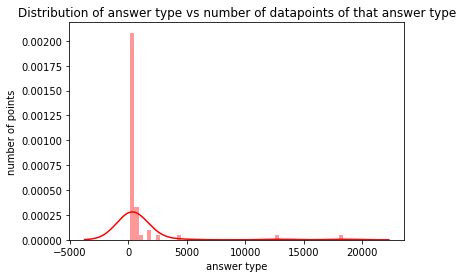

In [33]:
# Print the distribution of the answers
# --------------

plt.title('Distribution of answer type vs number of datapoints of that answer type')
plt.xlabel('answer type')
plt.ylabel('number of points')
plt.show()

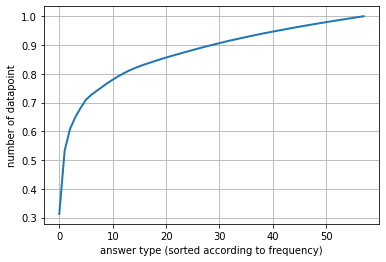

In [34]:
# Print how the types of answers cover the datapoints
# --------------

answer_count = sorted(list(answer_freq.values()), reverse=True) / np.sum(list(answer_freq.values()));
answer_count_cum = np.cumsum(answer_count)
plt.figure(1, figsize=(6, 4))
plt.clf()
plt.plot(answer_count_cum, linewidth=2)
plt.axis('tight')
plt.grid()
plt.xlabel('answer type (sorted according to frequency)')
plt.ylabel('number of datapoint')
plt.show()

In [35]:
# Print how much the types of answers cover the datapoints
# --------------

threshold = 0.875
idx = [i for i, elem in enumerate(answer_count_cum) if elem > threshold][0]
print(f'Top {idx + 1} answer-type covers about {threshold * 100}% of our train data')

Top 25 answer-type covers about 87.5% of our train data


In [37]:
# Print the frequency of the answers, which will be the classes in the model
# --------------

from prettytable import PrettyTable
x = PrettyTable()
x = PrettyTable(["Question Type", "Question Count", "Coverage(%)"])

for i in range(58):
    row = []
    row.append(top_answers[i])
    row.append(top_freq[i])
    row.append(np.round((top_freq[i]/sum(top_freq))*100, 2))
    x.add_row(row)

print(x)
print(top_answers)

+---------------+----------------+-------------+
| Question Type | Question Count | Coverage(%) |
+---------------+----------------+-------------+
|      yes      |     18386      |    31.25    |
|       no      |     12910      |    21.94    |
|       2       |      4450      |     7.56    |
|       1       |      2452      |     4.17    |
|      red      |      1880      |     3.2     |
|       3       |      1690      |     2.87    |
|     white     |      986       |     1.68    |
|      blue     |      804       |     1.37    |
|       4       |      793       |     1.35    |
|     yellow    |      792       |     1.35    |
|     brown     |      698       |     1.19    |
|      dog      |      683       |     1.16    |
|       0       |      594       |     1.01    |
|      cat      |      559       |     0.95    |
|       5       |      475       |     0.81    |
|    sitting    |      444       |     0.75    |
|     green     |      380       |     0.65    |
|     black     |   

In [54]:
# Calculate the weights of the answers, which are the classes, in order to use them in the weighted loss of the model
# --------------

labels_dict = {
        '0': 0,
        '1': 1,
        '2': 2,
        '3': 3,
        '4': 4,
        '5': 5,
        'apple': 6,
        'baseball': 7,
        'bench': 8,
        'bike': 9,
        'bird': 10,
        'black': 11,
        'blanket': 12,
        'blue': 13,
        'bone': 14,
        'book': 15,
        'boy': 16,
        'brown': 17,
        'cat': 18,
        'chair': 19,
        'couch': 20,
        'dog': 21,
        'floor': 22,
        'food': 23,
        'football': 24,
        'girl': 25,
        'grass': 26,
        'gray': 27,
        'green': 28,
        'left': 29,
        'log': 30,
        'man': 31,
        'monkey bars': 32,
        'no': 33,
        'nothing': 34,
        'orange': 35,
        'pie': 36,
        'plant': 37,
        'playing': 38,
        'red': 39,
        'right': 40,
        'rug': 41,
        'sandbox': 42,
        'sitting': 43,
        'sleeping': 44,
        'soccer': 45,
        'squirrel': 46,
        'standing': 47,
        'stool': 48,
        'sunny': 49,
        'table': 50,
        'tree': 51,
        'watermelon': 52,
        'white': 53,
        'wine': 54,
        'woman': 55,
        'yellow': 56,
        'yes': 57
}

result_weights = []

for i in tqdm.tqdm(labels_dict):
    index = top_answers.index(i)
    result_weights.append(1/top_freq[index])


total_sum = len(result_weights)

result_weights = [i*total_sum/num_classes for i in result_weights]

print(result_weights)


100%|██████████| 58/58 [00:00<?, ?it/s][30.95286195286195, 7.49836867862969, 4.131685393258427, 10.879289940828402, 23.185372005044137, 38.70736842105263, 94.28717948717949, 110.75903614457832, 89.68780487804878, 102.14444444444445, 88.82125603864733, 50.09809264305177, 90.12745098039215, 22.8681592039801, 103.29213483146067, 106.27745664739884, 81.35398230088495, 26.340974212034382, 32.890876565295166, 105.06285714285714, 60.48026315789473, 26.9194729136164, 55.047904191616766, 68.34944237918215, 62.325423728813554, 75.66255144032922, 90.12745098039215, 52.08498583569405, 48.38421052631579, 65.66428571428571, 77.57805907172995, 85.51627906976744, 96.26178010471205, 1.4241673121611154, 69.90874524714829, 75.66255144032922, 99.92391304347825, 67.10218978102189, 59.11897106109325, 9.779787234042553, 61.08305647840532, 70.98841698841699, 105.66666666666666, 41.409909909909906, 81.71555555555555, 56.57230769230769, 103.29213483146067, 106.8953488372093, 95.76041666666666, 92.39195979899498